In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from random import shuffle
import matplotlib.pyplot as plt
import copy
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

def openSamplingFile(filepath):
    file = open(filepath)
    dict_users = {}
    index = 0
    while True:
        line = file.readline()
        if line.rstrip('\n') == '':
            break
        temp = []
        line = line[0:len(line)-1]
        line = line.split(',')
        # print(line)
        for cur in line:
            temp.append(int(cur))
        dict_users[index] = set(temp)
        index += 1
        if not line:
            break
        pass
    file.close()
    return dict_users

In [2]:
# sample users
df= pd.read_csv("./data/heart_data/label_non_normal/heart.csv")
df_label = pd.read_csv("./data/heart_data/label_non_normal/heart_label.csv")
df.pop('0')
df_label.pop("0")
X_train, X_test, y_train, y_test = train_test_split(df,df_label, stratify=df_label, train_size=0.75,random_state=1)
y_train.loc[y_train["0.1"] == 1].index
len(X_train.index)
diab = pd.read_csv("data\heart_data\diabetes_binary_5050split_health_indicators_BRFSS2015.csv")
diab_label=pd.DataFrame(diab.pop("Diabetes_binary"))
X_dia_train, X_dia_test, y_dia_train, y_dia_test = train_test_split(diab,diab_label, stratify=diab_label, train_size=0.75,random_state=1)

In [3]:
data_idx = X_dia_train.index 
data_type = ['iid','biasnumber','biaslabel','both']
n_client =100

if "iid" in data_type:
    with open("iid_dia.txt","w") as f:
        pass
    num = int(len(data_idx)/n_client)
    for _ in range(n_client):
        index_1=np.random.choice(len(data_idx),num,replace=False)
        temp = data_idx[index_1]
        data_idx = np.delete(data_idx,index_1)
        with open('./iid_dia.txt','a') as f:
            print(*temp, sep=', ',file=f)

if "biasnumber" in data_type:
    data_idx = X_dia_train.index 
    with open("biasnum_dia.txt","w") as f:
        pass
    num_mean = int(len(data_idx)/n_client)
    for i in range(n_client):
        num=np.random.randint(int(0.4*num_mean),int(1.4*num_mean))
        if num<len(data_idx):
            index_1=np.random.choice(len(data_idx),num,replace=False)
            temp = data_idx[index_1]
            data_idx = np.delete(data_idx,index_1)
        elif len(data_idx)==0:
            raise Exception('not enough!')
        else:
            temp=data_idx
        with open('./biasnum_dia.txt','a') as f:
            print(*temp, sep=', ',file=f)

if "biaslabel" in data_type:
    data_idx = X_dia_train.index 
    with open("biaslabel_dia.txt","w") as f:
        pass
    pos_idx = y_dia_train.loc[y_dia_train["Diabetes_binary"] == 1].index
    neg_idx = y_dia_train.loc[y_dia_train["Diabetes_binary"] == 0].index
    num = int(len(data_idx)/n_client)
    ratio = 0.3
    for i in range(int(ratio*n_client)):
        index_1=np.random.choice(len(neg_idx),num,replace=False)
        temp = neg_idx[index_1]
        neg_idx = np.delete(neg_idx,index_1)
        with open('./biaslabel_dia.txt','a') as f:
            print(*temp, sep=', ',file=f)
    data_idx = np.append(pos_idx,neg_idx,axis=0)
    for j in range(i+1,n_client):
        index_1=np.random.choice(len(data_idx),num,replace=False)
        temp = data_idx[index_1]
        data_idx = np.delete(data_idx,index_1)
        with open('./biaslabel_dia.txt','a') as f:
            print(*temp, sep=', ',file=f) 
            
if "both" in data_type:
    data_idx = X_dia_train.index 
    with open("both_dia.txt","w") as f:
        pass
    pos_idx = y_dia_train.loc[y_dia_train["Diabetes_binary"] == 1].index
    neg_idx = y_dia_train.loc[y_dia_train["Diabetes_binary"] == 0].index
    ratio = 0.3
    num_mean = int(len(data_idx)/n_client)
    for i in range(int(ratio*n_client)):
        num=np.random.randint(int(0.4*num_mean),int(1.4*num_mean))
        index_1=np.random.choice(len(neg_idx),num,replace=False)
        temp = neg_idx[index_1]
        neg_idx = np.delete(neg_idx,index_1)
        with open('./both_dia.txt','a') as f:
            print(*temp, sep=', ',file=f)
    data_idx = np.append(pos_idx,neg_idx,axis=0)
    for j in range(i+1,n_client):
        num=np.random.randint(int(0.4*num_mean),int(1.4*num_mean))
        index_1=np.random.choice(len(data_idx),num,replace=False)
        temp = data_idx[index_1]
        data_idx = np.delete(data_idx,index_1)
        with open('./both_dia.txt','a') as f:
            print(*temp, sep=', ',file=f) 

In [3]:
class MLP(nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out):
        super(MLP, self).__init__()
        self.layer_input = nn.Linear(dim_in, dim_hidden)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
        self.layer_hidden = nn.Linear(dim_hidden, dim_hidden)
        self.layer_hidden2 = nn.Linear(dim_hidden, dim_out)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.layer_input(x)
        # x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_hidden(x)
        # x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_hidden2(x)
        return self.softmax(x)


In [4]:
class DatasetSplit(Dataset):
    def __init__(self, data_train,data_label, idxs):
        self.dataset_x = data_train
        self.dataset_y = data_label
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        # image, label = self.dataset[self.idxs[item]]
        image = np.array(self.dataset_x.loc[self.idxs[item]])
        label = np.array(self.dataset_y.loc[self.idxs[item]])
        return image, label


class LocalUpdate(object):
    def __init__(self, data_train , data_label, idxs=None):
        self.loss_func = nn.CrossEntropyLoss()
        self.selected_clients = []
        self.ldr_train = DataLoader(DatasetSplit(data_train,data_label, idxs), batch_size=128, shuffle=True)

    def train(self, net,local_ep):
        net.train()
        # train and update
        optimizer = torch.optim.SGD(net.parameters(), lr=args_lr, momentum=0.5)
        epoch_loss = []
        for iter in range(local_ep):
            batch_loss = []
            
            for batch_idx, (images, labels) in enumerate(self.ldr_train):
                labels = labels.type(torch.LongTensor) 
                images, labels = images.to(device), labels.to(device)
                net.zero_grad()
                
                log_probs = net(images.float())
                # labels = labels.view(128)
                loss = self.loss_func(log_probs, labels.squeeze(dim=1))
                loss.backward()
                optimizer.step()
                # if self.args.verbose and batch_idx % 10 == 0:
                #     print('Update Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #         iter, batch_idx * len(images), len(self.ldr_train.dataset),
                #                100. * batch_idx / len(self.ldr_train), loss.item()))
                batch_loss.append(loss.item())
            epoch_loss.append(np.sum(batch_loss)/len(batch_loss))
            
        return net.state_dict(), np.sum(epoch_loss) / len(epoch_loss)

def FedAvg(w):
    w_avg = copy.deepcopy(w[0])
    for k in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[k] += w[i][k]
        w_avg[k] = torch.div(w_avg[k], len(w))
    return w_avg

def test_img(net_g, data_train , data_label,idxs):
    net_g.eval()
    # testing
    test_loss = 0
    correct = 0
    data_loader = DataLoader(DatasetSplit(data_train,data_label, idxs), batch_size=128)
    l = len(data_loader)
    for idx, (data, target) in enumerate(data_loader):
        target = target.type(torch.LongTensor) 
        if torch.cuda.is_available():
            data, target = data.cuda(device), target.cuda(device)
        else:
            data, target = data.cpu(), target.cpu()
        log_probs = net_g(data.float())
        # sum up batch loss
        # target = target.view(1)
        test_loss += F.cross_entropy(log_probs, target.squeeze(), reduction='sum').item()
        # get the index of the max log-probability
        y_pred = log_probs.data.max(1, keepdim=True)[1]
        correct += y_pred.eq(target.data.view_as(y_pred)).long().cpu().sum()

    test_loss /= len(data_loader.dataset)
    accuracy = 100.00 * correct / len(data_loader.dataset)
    return accuracy, test_loss


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]           1,408
              ReLU-2                [-1, 1, 64]               0
            Linear-3                [-1, 1, 64]           4,160
              ReLU-4                [-1, 1, 64]               0
            Linear-5                 [-1, 1, 2]             130
           Softmax-6                 [-1, 1, 2]               0
Total params: 5,698
Trainable params: 5,698
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------
None
21
Round   0,Testing accuracy: 45.73
Round   1,Testing accuracy: 44.67
Round   2,Testing accuracy: 45.45
Round   3,Testing accuracy: 45.60
Round   4,Testing accuracy: 45

c:\Users\24411\anaconda3\envs\wp\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Round   0,Testing accuracy: 49.81
Round   1,Testing accuracy: 49.41
Round   2,Testing accuracy: 48.87
Round   3,Testing accuracy: 48.90
Round   4,Testing accuracy: 48.82
Round   5,Testing accuracy: 48.53
Round   6,Testing accuracy: 48.46
Round   7,Testing accuracy: 48.56
Round   8,Testing accuracy: 48.48
Round   9,Testing accuracy: 48.64
Round  10,Testing accuracy: 48.61
Round  11,Testing accuracy: 48.80
Round  12,Testing accuracy: 49.01
Round  13,Testing accuracy: 49.23
Round  14,Testing accuracy: 49.48
Round  15,Testing accuracy: 49.82
Round  16,Testing accuracy: 50.22
Round  17,Testing accuracy: 50.75
Round  18,Testing accuracy: 51.74
Round  19,Testing accuracy: 52.42
Round  20,Testing accuracy: 52.94
Round  21,Testing accuracy: 53.97
Round  22,Testing accuracy: 54.55
Round  23,Testing accuracy: 55.27
Round  24,Testing accuracy: 55.66
Round  25,Testing accuracy: 56.25
Round  26,Testing accuracy: 56.87
Round  27,Testing accuracy: 57.30
Round  28,Testing accuracy: 57.74
Round  29,Test

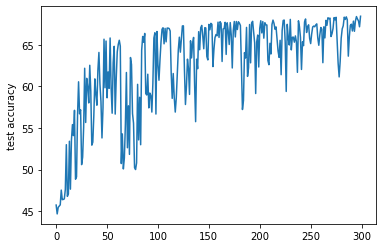

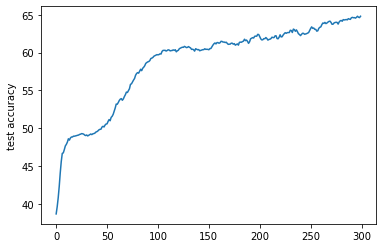

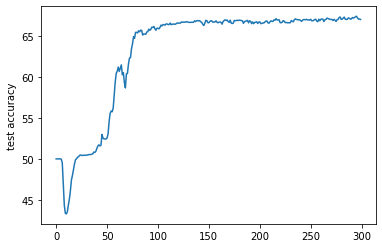

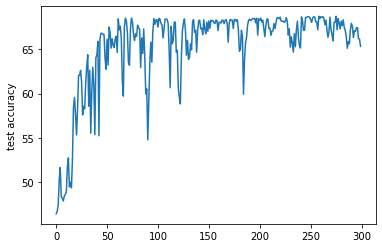

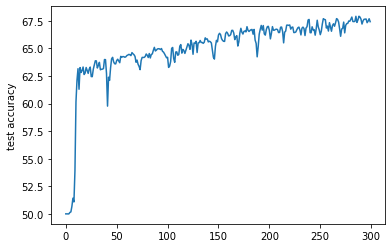

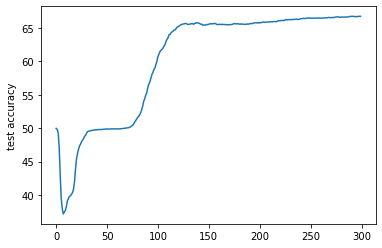

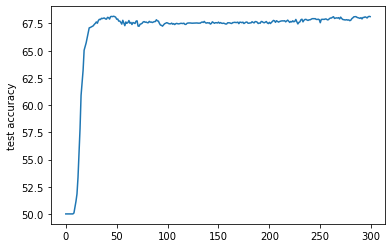

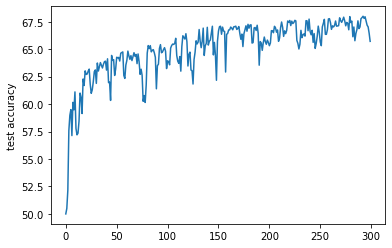

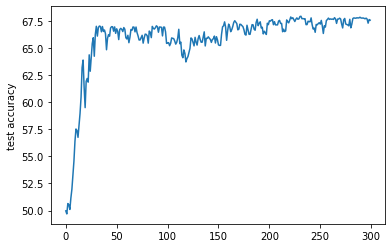

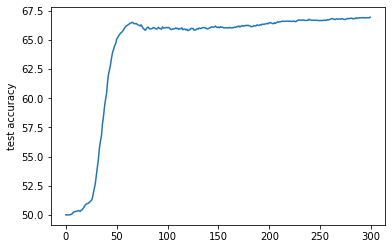

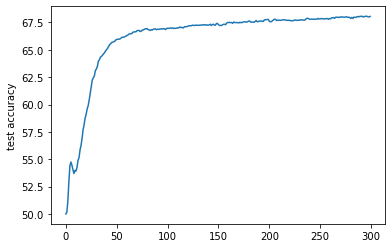

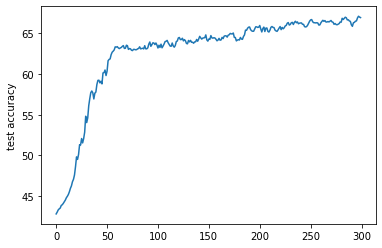

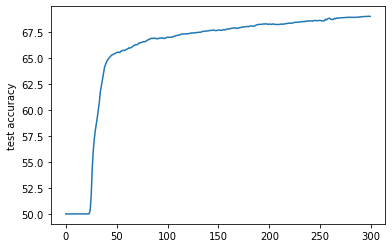

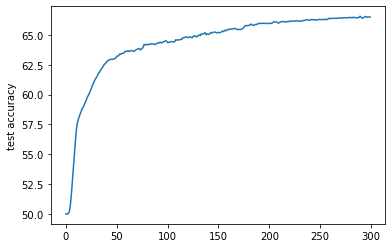

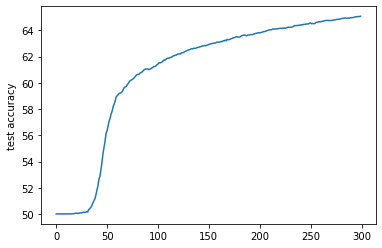

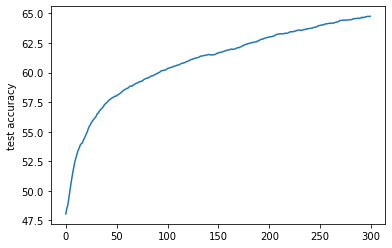

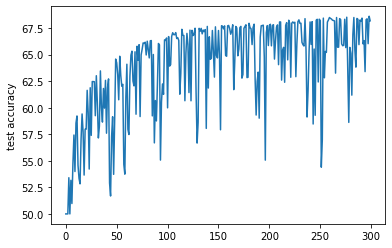

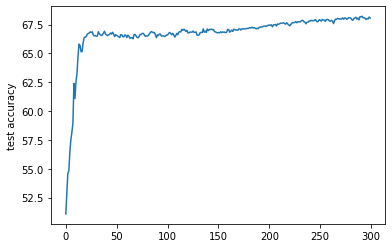

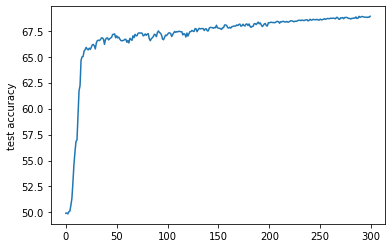

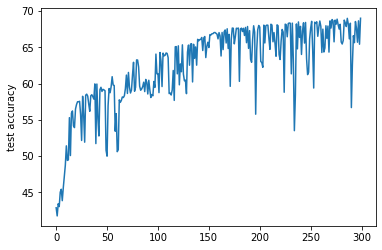

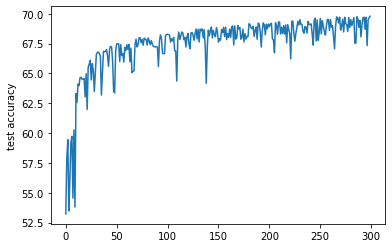

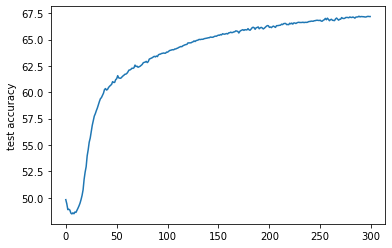

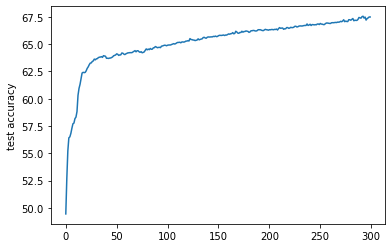

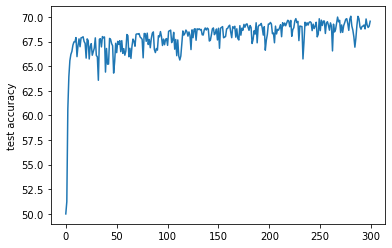

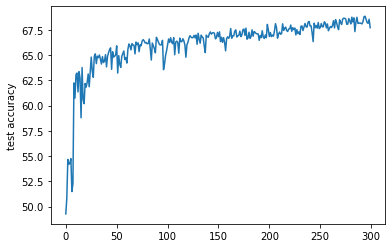

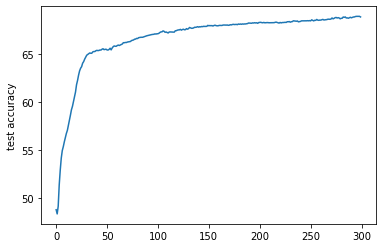

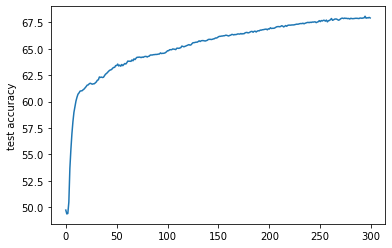

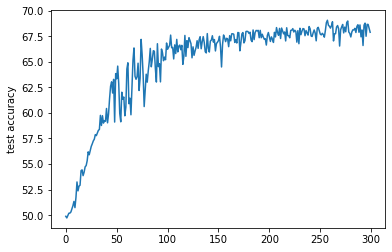

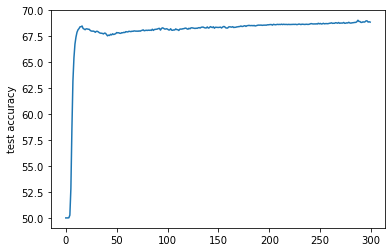

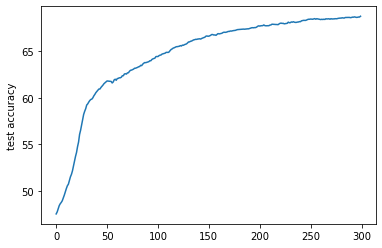

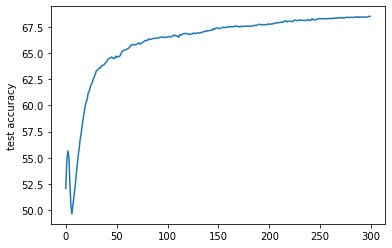

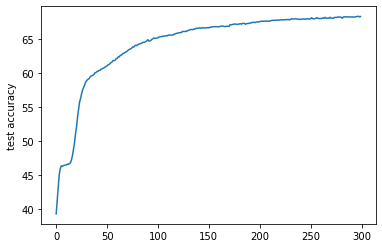

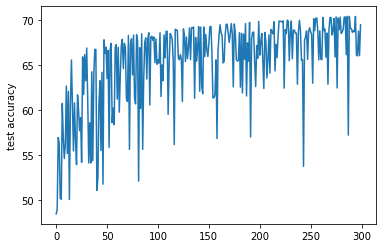

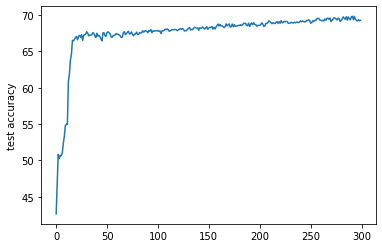

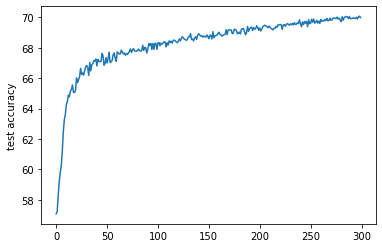

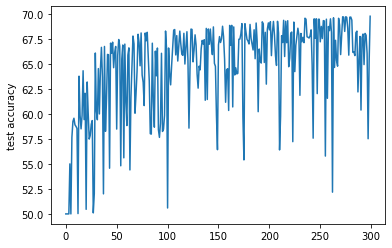

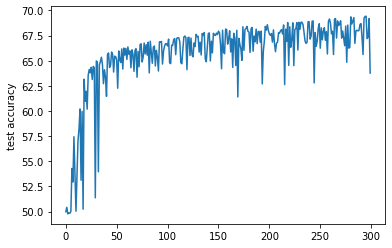

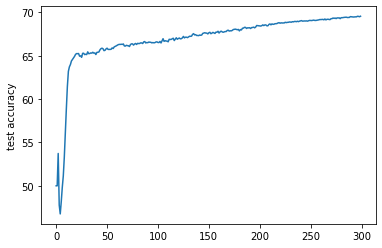

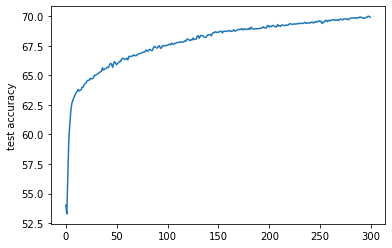

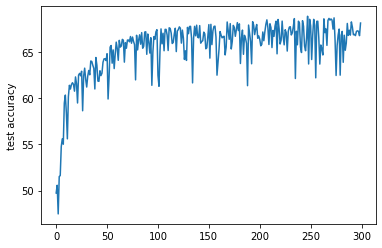

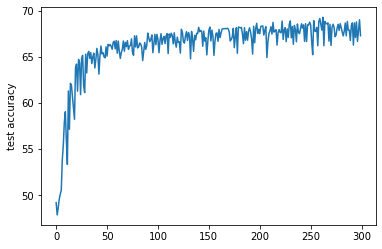

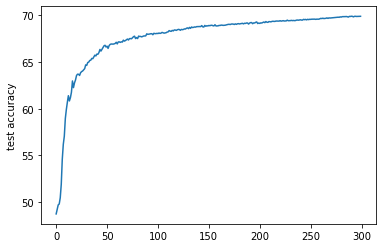

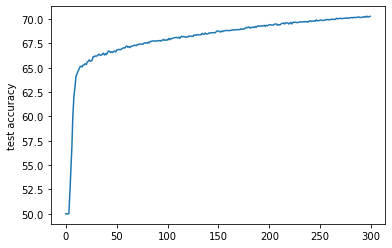

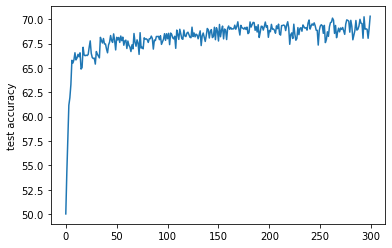

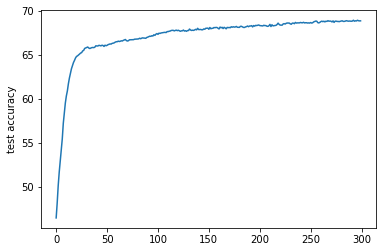

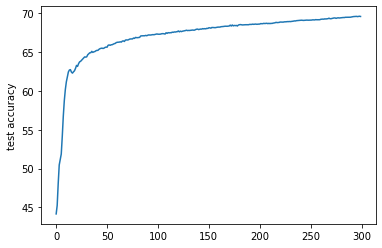

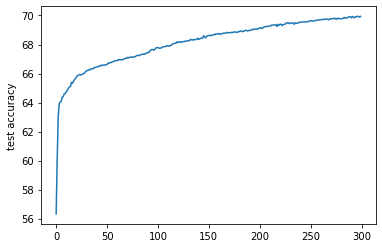

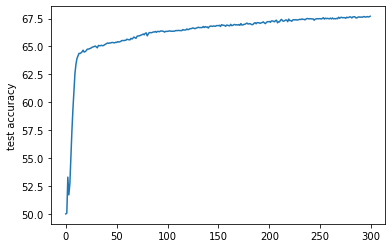

In [6]:
from torchsummary import summary
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
args_lr=0.001
args_epochs = 300
args_frac = 0.5 #how many client work
localep = 1
n_client = 100
device = torch.device('cuda:{}'.format(0) if torch.cuda.is_available() else 'cpu')
for localep in [1,2,4]:
    for args_frac in [0.1,0.4,0.7,1]:
        for txtdata in ['biaslabel_dia.txt','biasnum_dia.txt','iid_dia.txt',"both_dia.txt"]:
            dict_users = openSamplingFile(txtdata)
            net_glob = MLP(dim_in=int(X_dia_train.iloc[0].shape[0]), dim_hidden=64, dim_out=2).to(device)
            print(summary(net_glob, (1,int(X_dia_train.iloc[0].shape[0]))))
            print(int(X_dia_train.iloc[0].shape[0]))
            net_glob.train()
            w_glob = net_glob.state_dict()
            acc_test = []
            learning_rate = [args_lr for i in range(n_client)]
            for iter in range(args_epochs):
                w_locals, loss_locals = [], []
                m = max(int(args_frac * n_client), 1)
                idxs_users = np.random.choice(range(n_client), m, replace=False)
                for idx in idxs_users:
                    local = LocalUpdate(X_dia_train, y_dia_train, idxs=dict_users[idx])
                    w, loss = local.train(net=copy.deepcopy(net_glob).to(device),local_ep=localep)
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                # update global weights
                w_glob = FedAvg(w_locals)
                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print accuracy
                net_glob.eval()
                acc_t, loss_t = test_img(net_glob, X_dia_test,y_dia_test,idxs=np.array(y_dia_test.index))
                print("Round {:3d},Testing accuracy: {:.2f}".format(iter, acc_t))

                acc_test.append(acc_t.item())


            # plot loss curve
            plt.figure()
            plt.plot(range(len(acc_test)), acc_test)
            plt.ylabel('test accuracy')
            plt.savefig("localep"+str(localep)+txtdata[:-4]+str(args_frac)+".png")
            np.save("localep"+str(localep)+txtdata[:-4]+str(args_frac)+".npy",np.array(acc_test))


In [13]:
plt.figure()
plt.plot(range(len(acc_test)), acc_test)
plt.ylabel('test accuracy')
plt.savefig("./re.png")

In [42]:
from torchsummary import summary
args_lr=0.001
args_epochs = 200
args_frac = 1 #how many client work
device = torch.device('cuda:{}'.format(0) if torch.cuda.is_available() else 'cpu')
dict_users = openSamplingFile("both_dia.txt")
net_glob = MLP(dim_in=int(X_dia_train.iloc[0].shape[0]), dim_hidden=64, dim_out=2).to(device)
print(summary(net_glob, (1,int(X_dia_train.iloc[0].shape[0]))))
print(int(X_dia_train.iloc[0].shape[0]))
net_glob.train()
w_glob = net_glob.state_dict()
acc_test = []
learning_rate = [args_lr for i in range(n_client)]
for iter in range(args_epochs):
    w_locals, loss_locals = [], []
    m = max(int(args_frac * n_client), 1)
    idxs_users = np.random.choice(range(n_client), m, replace=False)
    for idx in idxs_users:
        local = LocalUpdate(X_dia_train, y_dia_train, idxs=dict_users[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(device))
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))

    # update global weights
    w_glob = FedAvg(w_locals)
    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)

    # print accuracy
    net_glob.eval()
    acc_t, loss_t = test_img(net_glob, X_dia_test,y_dia_test,idxs=np.array(y_dia_test.index))
    print("Round {:3d},Testing accuracy: {:.2f}".format(iter, acc_t))

    acc_test.append(acc_t.item())


# plot loss curve
plt.figure()
plt.plot(range(len(acc_test)), acc_test)
plt.ylabel('test accuracy')
plt.savefig(str(args_lr)+txtdata+str(args_frac)+".png")
np.save(str(args_lr)+txtdata+str(args_frac)+".npy",np.array(acc_test))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_mm)